### Introduction
This is a multi-label classification problem. I.e. you need to predict 206 labels  for each row in the test set.
Since shallow learning methods like gradient boosting do not work great on multi-label problems, you may need to have one model for each target so you may end up 200+ models. So we are aiming for neural net based single model to predict 206 labels.

These 206 labels represent the properties (affects) of each drug (row). Each drug can exhibit one or more properties/affects. (i.e. Multi-Label)

### Thanks to
Abhishek and Andrew for their [live coding session](https://www.youtube.com/watch?v=VRVit0-0AXE) from which lots of code here is inspired.

- Multi-label classification - A row can belong to multiple classes SIMULTANEOUSLY
- Multi-class classification - Classify a row into ONE of multiple possible classes . (One class at a time).

### Hyper Parameters from Optune
https://www.kaggle.com/krisho007/moa-pytorch-lightning-params-tuning-optuna

In [1]:
LR = 0.001462129310551811
# LR = 0.008
N_LAYERS = 5
F_DROPOUT = 0.407
LAYERS = [987,1206,2390,2498,3449]

In [2]:
LABEL_SMOOTHING = 0.008

In [3]:
# Install required modules only once
import sys
import subprocess
import pkg_resources

required = {'iterative-stratification', 'pytorch-lightning'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
from ranger_py import Ranger
from mish_activation import *  

In [5]:
test_features = pd.read_csv('../input/lish-moa/test_features.csv')
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [6]:
# Though number of rows is not huge, number of features is 875, 
# which is very huge here, unlike in common cases.
train_features.shape, test_features.shape, train_targets_scored.shape

((23814, 876), (3982, 876), (23814, 207))

In [7]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [8]:
train_features.cp_type.value_counts(), train_features.cp_time.value_counts(), train_features.cp_dose.value_counts()

(trt_cp         21948
 ctl_vehicle     1866
 Name: cp_type, dtype: int64,
 48    8250
 72    7792
 24    7772
 Name: cp_time, dtype: int64,
 D1    12147
 D2    11667
 Name: cp_dose, dtype: int64)

'ctl_vehicle' indicates that these rows are not treated. Meaning targets for these can be set as zero. https://www.kaggle.com/c/lish-moa/discussion/180165
cp_time indicates How long each row was treated for?
Next we have 772 gene features (prefixed with g) and 100 cell features (prefixed with c). 

In [9]:
train_targets_scored.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Column wise sums across all rows
train_targets_scored.sum()[1:].sort_values().head(100)

atp-sensitive_potassium_channel_antagonist     1
erbb2_inhibitor                                1
diuretic                                       6
autotaxin_inhibitor                            6
protein_phosphatase_inhibitor                  6
                                              ..
corticosteroid_agonist                        36
angiotensin_receptor_antagonist               37
thymidylate_synthase_inhibitor                37
orexin_receptor_antagonist                    37
igf-1_inhibitor                               37
Length: 100, dtype: object

As you see there are atleast two columns which have 1 occurance only once. Andrey: "Better to mark these as all zeros". Maximum occurance is 832 (out of 20k+) so this is a very much unbalanced dataset, so this is going to be complicated.

Let us look at g-values in a single row.

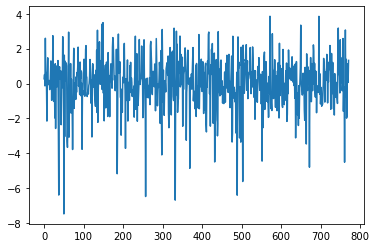

In [11]:
gs = train_features[7:8][[col for col in train_features.columns if 'g-' in col]].values.reshape(-1, 1)
plt.plot(gs)

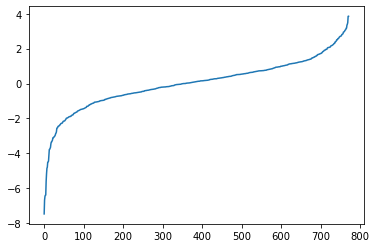

In [12]:
plt.plot(sorted(gs))

772 columns in all rows have the same spread as above. Mysterious why values always follow this curve. Even the c- columns also have a similar graph and all rows follow the same pattern. Originally observed by @shadab

(array([1.0000e+00, 1.7000e+01, 5.5000e+02, 1.2976e+04, 9.5540e+03,
        4.5100e+02, 1.7400e+02, 4.7000e+01, 3.0000e+01, 1.4000e+01]),
 array([-6.577 , -4.9193, -3.2616, -1.6039,  0.0538,  1.7115,  3.3692,
         5.0269,  6.6846,  8.3423, 10.    ]),
 <a list of 10 Patch objects>)

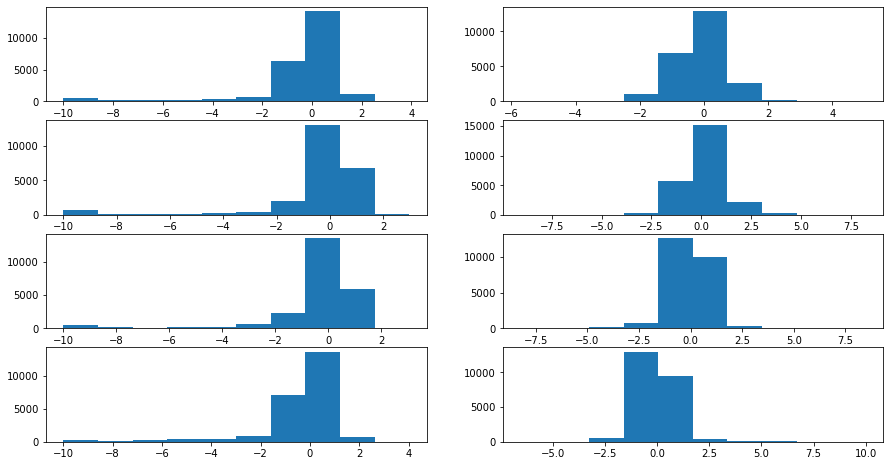

In [13]:
# Let us look at spread of each columns
figure = plt.figure(figsize=(15,8))
ax1 = figure.add_subplot(4,2,1)
ax2 = figure.add_subplot(4,2,2)
ax3 = figure.add_subplot(4,2,3)
ax4 = figure.add_subplot(4,2,4)
ax5 = figure.add_subplot(4,2,5)
ax6 = figure.add_subplot(4,2,6)
ax7 = figure.add_subplot(4,2,7)
ax8 = figure.add_subplot(4,2,8)

ax1.hist(train_features['c-1'])
ax2.hist(train_features['g-1'])
ax3.hist(train_features['c-2'])
ax4.hist(train_features['g-2'])
ax5.hist(train_features['c-25'])
ax6.hist(train_features['g-25'])
ax7.hist(train_features['c-49'])
ax8.hist(train_features['g-49'])

Since all these seem to be zero centered, it looks like the data was normalized and a noise added later?

### Dataset
Dataset is used by the Pytorch framework to read data, and find total length. This is where we convert data into Pytorch Tensors.

In [14]:
class MoADataset(Dataset):
    
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return self.features.shape[0]
        
    def __getitem__(self, index):
        return {
            "x": torch.tensor(self.features[index, :], dtype=torch.float),
            "y": torch.tensor(self.targets[index, :], dtype=torch.float)
        }
    

### Datamodule

In [15]:
class MoADataModule(pl.LightningDataModule):
    def __init__(self, batch_size=1024, fold= 0):
        super().__init__()
        self.batch_size = batch_size
        self.fold = fold
        
    def prepare_data(self):
        # Even in multi-GPU training. this method is called only from a single GPU. 
        # So this method ideal for download, stratification etc. 
        # Startification on multi-label dataset is tricky. 
        # scikit-learn stratified KFold cannot be used. 
        # So we are using interative-stratification
        if os.path.isfile("train_folds.csv"):
            return
        complete_training_data = self._read_data()        
        self._startify_and_save(complete_training_data)        
        
    def _read_data(self):
        features = pd.read_csv('../input/lish-moa/train_features.csv')
        # Convert categorical features into OHE
        features = pd.concat([features, pd.get_dummies(features['cp_time'], prefix='cp_time')], axis=1)
        features = pd.concat([features, pd.get_dummies(features['cp_dose'], prefix='cp_dose')], axis=1)
        features = pd.concat([features, pd.get_dummies(features['cp_type'], prefix='cp_type')], axis=1)
        # Delete original categorical features
        features = features.drop(['cp_time', 'cp_dose', 'cp_type'], axis=1)
        targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
        merged = features.merge(targets_scored, how="inner", on="sig_id")
        return merged
        
    def _startify_and_save(self, data):
        # New column to hold the fold number
        data.loc[:, "kfold"] = -1

        # Shuffle the dataframe
        data = data.sample(frac=1).reset_index(drop=True)        
        
        # 5 Folds
        mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=False, random_state=None) 
        # trn_ and val_ are indices
        targets = data.drop(['kfold', 'sig_id'], axis=1)                                                                                       
        for fold_, (trn_,val_) in enumerate(mskf.split(X=data, y=targets.iloc[:, 879:])): 
            # We are just filling the vaidation indices. 
            # All other data are for training (trn indices are not required)
            data.loc[val_, "kfold"] = fold_
    
        # We are saving the result to the disk so that other GPUs can pick it from there. 
        # Rather if we do "self.startified_data = train_targets_scored", 
        # other GPUs will not be able to read this 
        data.to_csv("train_folds.csv", index=False)   
        
    def setup(self, stage=None):
        # In multi-GPU training, this method is run on each GPU. 
        # So ideal for each training/valid split
        data = pd.read_csv("train_folds.csv")
        
        training_data = data[data.kfold != self.fold]
        training_data = training_data.drop(['kfold', 'sig_id'], axis=1)
        validation_data = data[data.kfold == self.fold]
        validation_data = validation_data.drop(['kfold', 'sig_id'], axis=1)
        self.train_dataset = MoADataset(training_data.iloc[:, :879].values, training_data.iloc[:, 879:].values)
        self.valid_dataset = MoADataset(validation_data.iloc[:, :879].values, validation_data.iloc[:, 879:].values)        

    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, self.batch_size, num_workers=4, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.valid_dataset, self.batch_size, num_workers=4, shuffle=False)    
            
        

### NN Model

In [16]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets):
        super().__init__()
        layers = []
        
        # Intermediate layers
        in_size = num_features   
        for i in range(N_LAYERS):
            out_size = LAYERS[i]
            layers.append(torch.nn.Linear(in_size, out_size, bias=False))
            layers.append(nn.BatchNorm1d(out_size))
            layers.append(nn.Dropout(F_DROPOUT))
            layers.append(nn.PReLU())
#             layers.append(nn.BatchNorm1d(in_size))
#             layers.append(nn.Dropout(F_DROPOUT))    
#             layers.append(torch.nn.Linear(in_size, out_size))
#             layers.append(nn.PReLU())
#             layers.append(Mish())
            in_size = out_size

        # Final layer
        layers.append(torch.nn.Linear(in_size, num_targets))    
        self.model = torch.nn.Sequential(*layers)        
        
        # Initialize weights
        self.model.apply(self._init_weights)
        
    def _init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            if m.bias != None:
                m.bias.data.fill_(0.01)
        
    def forward(self, x):
        x = self.model(x)
        return x

### Lightning Model

In [17]:
class PLitMoAModule(pl.LightningModule):
    def __init__(self, hparams, model):
        super(PLitMoAModule, self).__init__()
        self.hparams = hparams
        self.model = model
        self.criterion = nn.BCEWithLogitsLoss()
#         self.criterion = nn.BCELoss()
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams["lr"] )
#         optimizer = Ranger(self.model.parameters(), lr=self.hparams["lr"] )
        scheduler = {"scheduler": 
                     torch.optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer, patience=2, 
                        threshold=0.00003, 
                        mode='min', verbose=True),
                    "interval": "epoch",
                    "monitor": "val_loss"}
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_index):
        features = batch['x']
        targets = batch['y']
        out = self(features)
        targets_smooth = targets.float() * (1 - LABEL_SMOOTHING) + 0.5 * LABEL_SMOOTHING
        loss = self.criterion(out, targets_smooth)
        logs = {"train_loss" : loss}
        return {"loss": loss, "log": logs, "progress_bar": logs}
    
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        logs = {"train_loss": avg_loss}
        return {"log": logs, "progress_bar": logs}
            
    def validation_step(self, batch, batch_index):
        features = batch['x']
        targets = batch['y']
        out = self(features)
        loss = self.criterion(out, targets)
        logs = {"val_loss" : loss}
        return {"loss": loss, "log": logs, "progress_bar": logs}
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        logs = {"val_loss": avg_loss}
        return {"log": logs, "progress_bar": logs}

### Train

In [18]:
# Five fold training. 
for k in range(5):  
    
    checkpoint_callback = ModelCheckpoint(
        filepath='./models/model_{epoch:02d}', 
        monitor='val_loss', verbose=False, 
        save_last=False, save_top_k=1, save_weights_only=False, 
        mode='min', period=1, prefix='')
    trainer = pl.Trainer(gpus=-1 if torch.cuda.is_available() else None, max_epochs=30, checkpoint_callback=checkpoint_callback)
    dm = MoADataModule(fold=k)
    net = Model(879, 206) # Input Features, Output Targets
    pylitModel = PLitMoAModule(hparams={"lr":LR}, model=net)
    trainer.fit(pylitModel, dm)
    
    print(checkpoint_callback.best_model_path)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=False, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Model             | 20 M  
1 | criterion | BCEWithLogitsLoss | 0     


Epoch    13: reducing learning rate of group 0 to 1.4621e-04.


Epoch    19: reducing learning rate of group 0 to 1.4621e-05.


Epoch    22: reducing learning rate of group 0 to 1.4621e-06.


Epoch    26: reducing learning rate of group 0 to 1.4621e-07.


Epoch    29: reducing learning rate of group 0 to 1.4621e-08.


Saving latest checkpoint..
GPU available: True, used: True



/kaggle/working/models/model_epoch=22.ckpt


TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Model             | 20 M  
1 | criterion | BCEWithLogitsLoss | 0     


Epoch    12: reducing learning rate of group 0 to 1.4621e-04.


Epoch    22: reducing learning rate of group 0 to 1.4621e-05.


Epoch    25: reducing learning rate of group 0 to 1.4621e-06.


Epoch    28: reducing learning rate of group 0 to 1.4621e-07.


Saving latest checkpoint..
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]



/kaggle/working/models/model_epoch=18.ckpt


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Model             | 20 M  
1 | criterion | BCEWithLogitsLoss | 0     


Epoch    21: reducing learning rate of group 0 to 1.4621e-04.


Epoch    26: reducing learning rate of group 0 to 1.4621e-05.


Epoch    29: reducing learning rate of group 0 to 1.4621e-06.


Saving latest checkpoint..
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]



/kaggle/working/models/model_epoch=22_v0.ckpt


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Model             | 20 M  
1 | criterion | BCEWithLogitsLoss | 0     


Saving latest checkpoint..
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]



/kaggle/working/models/model_epoch=28.ckpt


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Model             | 20 M  
1 | criterion | BCEWithLogitsLoss | 0     


Epoch    14: reducing learning rate of group 0 to 1.4621e-04.


Epoch    18: reducing learning rate of group 0 to 1.4621e-05.


Epoch    25: reducing learning rate of group 0 to 1.4621e-06.


Epoch    28: reducing learning rate of group 0 to 1.4621e-07.


Saving latest checkpoint..



/kaggle/working/models/model_epoch=21.ckpt


### Inference
https://www.kaggle.com/krisho007/moa-pytorch-lightning-inference

### ToDO
- https://autogluon.mxnet.io/
- TabNet
- LabelSmoothing